In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('../')) 
sys.path.insert(0, module_path)


import pandas as pd
from pathlib import Path
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")

import katspace
import katspace.core
import katspace.data
import katspace.plot

from katspace.data import chunker, chunk_lengths
from katspace.plot import hist_heatmap as plot_hist_heatmap

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter

import numpy as np

from katspace.core import DATA_DIR, DRIVE_DIR, SPACE_TYPES, RESULTS_DIR

RESULTS_DIR_GB = Path(RESULTS_DIR, "predict-286-gutenberg")

Configuration file /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/katspace_config.json not found in /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/notebooks


In [2]:
def plot_preprocess(results, num_chunks=20, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space"), results_format = "parquet"):
    #ignore files without results
    results = {filename: result for filename, result  in results.items() if result != None}

    #ignore files with fewer than num_chunks sentences
    results = {filename: result for filename, result  in results.items() if len(result) >= num_chunks}

    print(f"Ignoring {len([filename for filename, result  in results.items() if len(result) < num_chunks])} files because they have too few sents")

    if results_format != "parquet":
      labels = {filename: [result["label"] for result in results[filename]] for filename in results.keys()}
    else:
      labels = results

    chunked_labels = {filename: chunker(labels[filename], num_chunks=num_chunks) for filename in labels.keys()}
    chunk_sizes = {filename: [len(chunk) for chunk in chunked_labels[filename]] for filename in labels.keys()}
    chunk_size_zero = [filename for filename in labels.keys() if chunk_sizes[filename] == 0]
    if len(chunk_size_zero) > 0:
      print(f"The followowing files have chunks of size 0: \n {chunk_size_zero}")

    counters = {filename: [Counter(label_chunk) for label_chunk in chunked_labels[filename]] for filename in chunked_labels.keys()}

    def total_sum(counter, sum_sel):
        num = [counter[space_type] for space_type in sum_sel]
        return sum(num)

    # change order of indexing to have space type as outermost index
    count_dict = {space_type: {filename: [counter[space_type] for counter in counters[filename]] for filename in counters.keys()} for space_type in SPACE_TYPES}

    count_dict["all_space"] = {}
    for filename in counters.keys():
      count_dict["all_space"][filename] = [total_sum(counter, sum_sel) for counter in counters[filename]]

    return count_dict, chunk_sizes

def plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = 20, debug_msg = ""):

    y = []
    x = []

    for filename in count_dict.keys():
        for c, size in enumerate(chunk_sizes[filename]):
          if size == 0:
            print(f"chunk nr {c} has size zero: {filename}")
            
        norm_counts_np = np.array(count_dict[filename]) / np.array(chunk_sizes[filename])
        y += list(norm_counts_np)
        x += range(1, num_chunks + 1)
        if len(x) != len(y):
          print(f"x and y have different lengths: {filename}, {debug_msg} \n ++++++ x: {x}, \n ++++++ y: {y}")
          break
    return x,y

def plot_hist(count_dict, chunk_sizes, title = "", fig = None, ax = None, bins = [20, 20], **kwargs):

    num_chunks = bins[0]

    x,y = plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = num_chunks, debug_msg = title)
    ax.set_title(title)
    ax.set_xlabel("Narrative section")
    ax.set_ylabel("Frequency")
    ax.hist2d(x, y, bins = bins, **kwargs)

def plot_violin(count_dict, chunk_sizes, num_chunks, title = "", fig = None, ax = None, **kwargs):
    
    data = [[count_dict[filename][col] / chunk_sizes[filename][col] for filename in count_dict.keys()] for col in range(0, num_chunks)]
    pos = range(0, num_chunks)
    ax.violinplot(data, pos, points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
    ax.set_title(title)


def plot_narrative_time_stats(results, num_chunks=20, plot_type = "histogram", space_types=("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space"),
                                total=False, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space")):

    count_dict, chunk_sizes = plot_preprocess(results, num_chunks, sum_sel)
    vert_num_chunks = 20

    if total == True:
      space_types = list(space_types) + ["all_space"]

    if plot_type == "histogram":
      #ToDo: Use new color scheme
      color = {"perceived_space": "Blues",
                "action_space": "Greens",
                "visual_space": "Reds",
                "descriptive_space": "GnBu",
                "no_space": "Greys",
                "all_space": 'Purples'
                }


      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(3, len(space_types) * 3),
                        layout="constrained") 

      for i, space_type in enumerate(space_types):
        plot_hist(count_dict[space_type], chunk_sizes, title = space_type, fig = fig, ax = axs[i], bins = [num_chunks, vert_num_chunks], cmap = color[space_type])

    elif plot_type == "violin":     
      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(10, len(space_types) * 6),
                        layout="constrained")
     
      for i, space_type in enumerate(space_types):
        plot_violin(count_dict[space_type], chunk_sizes, num_chunks, title = space_type, fig = fig, ax = axs[i])
    
    elif plot_type == "lineplot":
      pass
    plt.show()
  
def non_empty_labels_from_iter(series):
  while True:
    next_element = next(series, "")
    if next_element == "":
      break
    else:
      yield next_element

In [3]:
non_canon_df = pd.read_excel(Path(DATA_DIR, "2024-08-19_gutenberg_master_without_canon.xlsx"))
canon_df = pd.read_excel(Path(DATA_DIR, "20240818_canon_master_merged.xlsx"))

In [4]:
#read parquet

from pandas.io.parquet import read_parquet
fp_labels_df = Path(RESULTS_DIR, "2024_08_16_labels_df.parquet")
results_df = read_parquet(fp_labels_df)


results = {filename: list(non_empty_labels_from_iter(iter(results_df[filename]))) for filename in results_df.columns}

Ignoring 0 files because they have too few sents


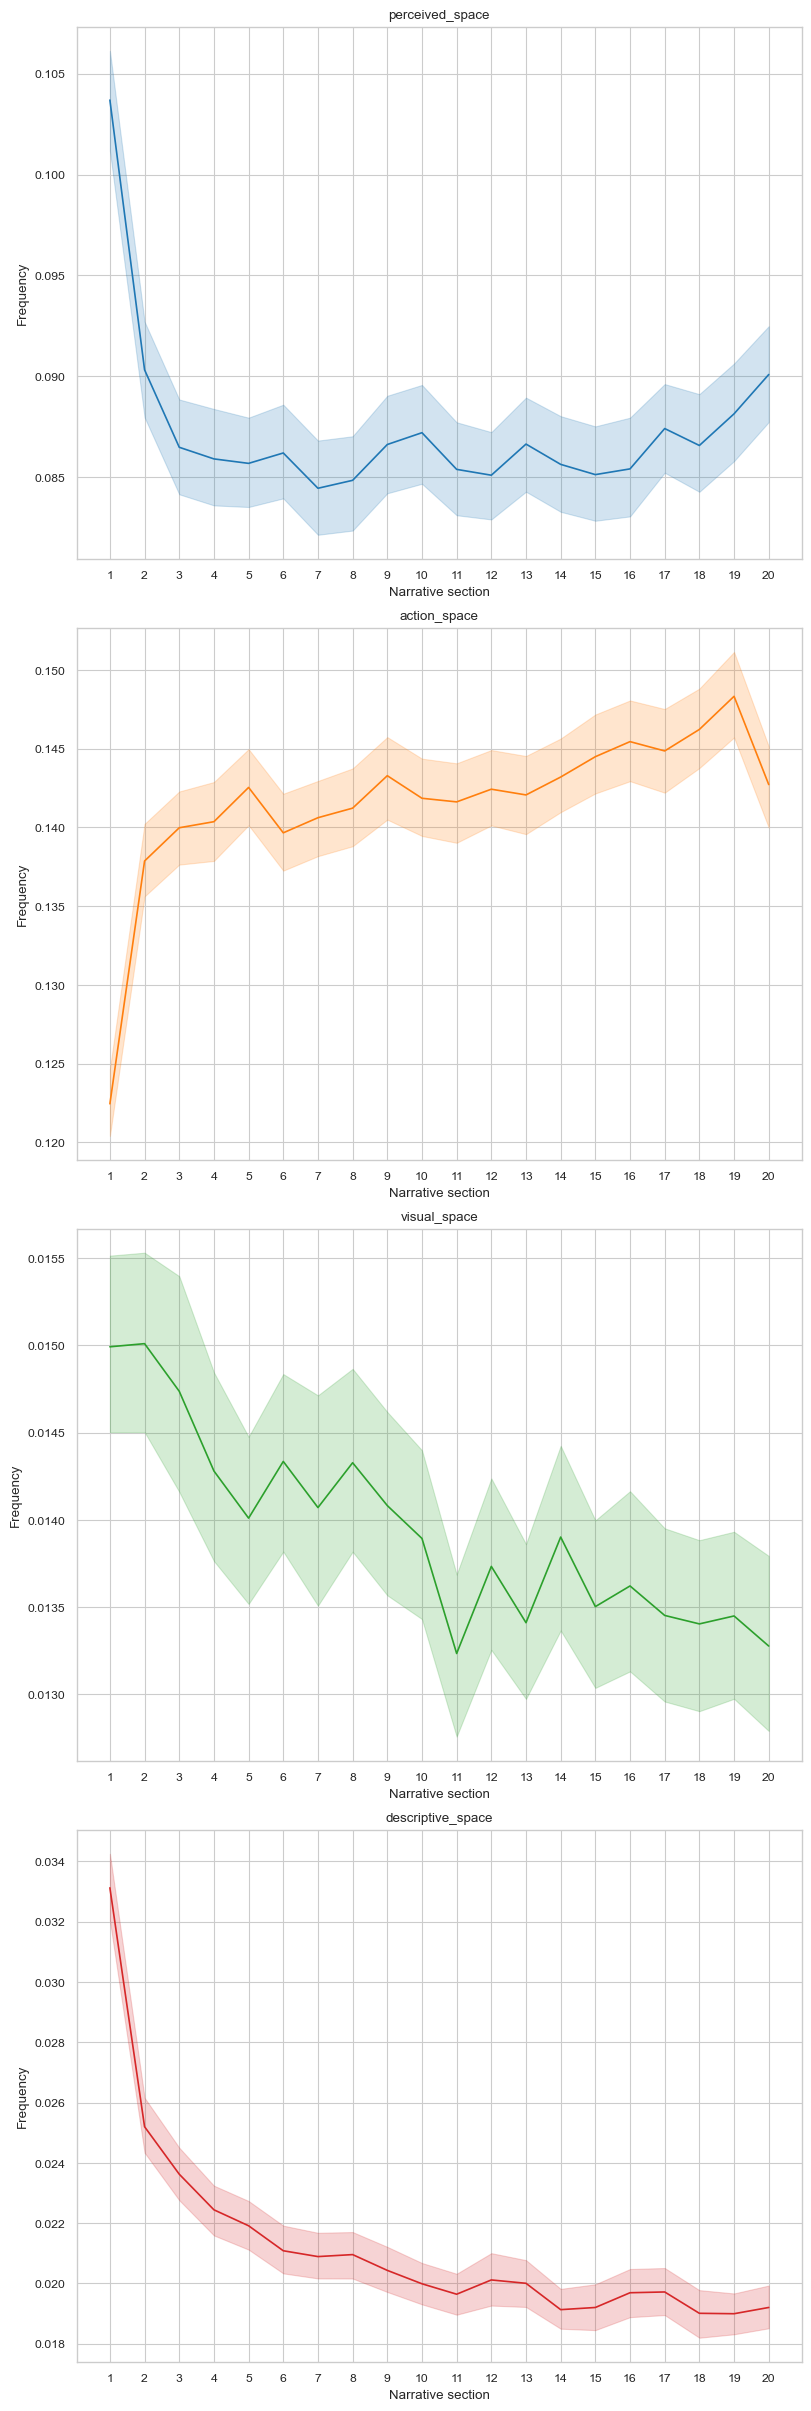

In [5]:
num_chunks = 20
sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space")
count_dict, chunk_sizes = plot_preprocess(results, num_chunks, sum_sel)

color_indexer = {'action_space': 1,
 'perceived_space': 0,
 'visual_space': 2,
 'descriptive_space': 3,
 'all_space': 4}

palettes = {space_type : [sns.color_palette("pastel").as_hex()[i], sns.color_palette().as_hex()[i]] for space_type, i in color_indexer.items()}


fig, axs = plt.subplots(ncols=1, nrows=len(katspace.core.space_types_pos), figsize=(8, len(katspace.core.space_types_pos) * 6),
                    layout="constrained")

for ax, space_type in zip(axs, katspace.core.space_types_pos):
    ax.set_title(space_type)
    ax.set_xlabel("Narrative section")
    ax.set_ylabel("Frequency")
    x,y = plot_hist_preprocess(count_dict[space_type], chunk_sizes, num_chunks = num_chunks, debug_msg = space_type)

    ax.set_xticks(range(1,21))
    
    sns.lineplot(x = x, y = y, ax = ax, color = sns.color_palette()[color_indexer[space_type]]) 

Ignoring 0 files because they have too few sents


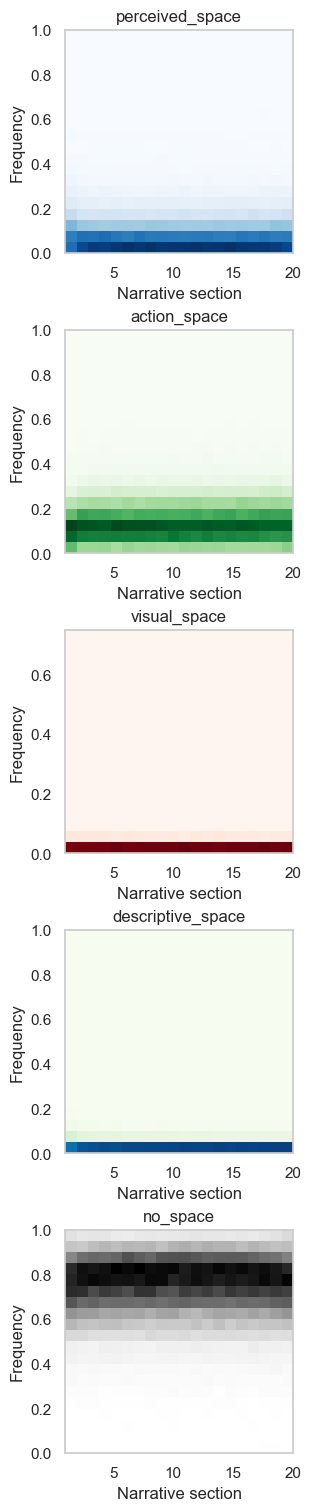

In [6]:
plot_narrative_time_stats(results, num_chunks = 20)